---
# Trabalho 1 - T√≥picos Especiais em Matem√°tica Aplicada

**Alunos/Matricula:** Jo√£o V. Farias & Renan V. Guedes / 221022604 & 221031363

**Arquitetura Usada:** Encoder-Decoder

**Dataset Link:** V1: [D-Talk](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatefr_to_pt) from TensorFlow.Datasets

---

### **Projeto para traduzir mensagens do Franc√™s para o Portugues**  

Neste projeto, vamos explorar e comparar tr√™s arquiteturas de redes neurais para tradu√ß√£o autom√°tica do franc√™s para o portugu√™s, usando o *dataset* TED Talks do *Open Translation Project*. A ideia √© testar modelos do tipo **Encoder-Decoder**, analisando suas diferen√ßas e impacto na qualidade da tradu√ß√£o.  

Os tr√™s modelos que vamos treinar s√£o:  

1. **LSTM (Long Short-Term Memory)**  
   - Um modelo b√°sico de rede recorrente bidirecional. O **Encoder** processa a frase em franc√™s e gera um contexto, enquanto o **Decoder** usa esse contexto para formar a tradu√ß√£o em portugu√™s.  
   - A principal vantagem desse modelo √© sua capacidade de lidar com depend√™ncias de longo prazo nas sequ√™ncias.  

2. **LSTM com Mecanismos de Aten√ß√£o**  
   - Uma vers√£o aprimorada do modelo anterior, adicionando camadas de aten√ß√£o (produto escalar, Bahdanau e Luong).  
   - A aten√ß√£o ajuda o modelo a "olhar" para partes espec√≠ficas da frase de entrada enquanto traduz, melhorando a coer√™ncia e precis√£o.  

3. **Transformers**  
   - Uma abordagem mais moderna, baseada em **autoaten√ß√£o**, eliminando o uso de redes recorrentes.  
   - Trabalha com processamento paralelo, usando *Multi-Head Attention* e *Positional Encoding* para entender rela√ß√µes entre palavras, mesmo quando est√£o distantes na frase.  

**Como vamos testar os modelos?**  
- **Dataset**: Vamos usar cerca de 52.000 pares de frases (franc√™s-portugu√™s) para treinar, al√©m de 1.200 para valida√ß√£o e 1.800 para teste.  
- **Pr√©-processamento**: Faremos a tokeniza√ß√£o com *SubwordTextEncoder* para reduzir palavras fora do vocabul√°rio (*out-of-vocabulary* ‚Äì OOV).  
- **Treinamento**: Otimiza√ß√£o com Adam, acompanhando a perda (*loss*) e a acur√°cia durante o processo.  
- **Avalia√ß√£o**: Vamos comparar os resultados usando a m√©trica BLEU e analisar exemplos pr√°ticos das tradu√ß√µes.  

**O que esperamos encontrar?**  
- Nosso objetivo √© entender qual desses modelos tem o melhor equil√≠brio entre qualidade de tradu√ß√£o e efici√™ncia computacional.  
- √â prov√°vel que os Transformers tenham um desempenho superior, j√° que conseguem processar frases de forma mais eficiente, enquanto os modelos com LSTM e aten√ß√£o devem mostrar um avan√ßo significativo sobre a vers√£o b√°sica de LSTM.  

No fim das contas, essa an√°lise pode ajudar a compreender melhor como diferentes abordagens de deep learning se saem em tarefas de tradu√ß√£o, trazendo insights √∫teis para aplica√ß√µes reais em NLP.

---

## üìö Importando as bibliotecas necess√°rias

In [1]:
# Primeiro, vamos importar todas as bibliotecas que vamos precisar ao longo do Projeto
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Para processamento de texto
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Componentes do Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

# Para visualiza√ß√£o dos resultados
from sklearn.metrics import confusion_matrix

tf.config.optimizer.set_jit(True)  # Ativa o XLA JIT compilation
tf.keras.mixed_precision.set_global_policy('mixed_float16') # For√ßa o TensorFlow a usar precis√£o mista

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## üîç Carregando e Preparando os Dados

In [36]:
#Agora vamos carregar nosso dataset de tradu√ß√£o
examples, metadata = tfds.load('ted_hrlr_translate/fr_to_pt', with_info=True,
                             as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# Fun√ß√£o para preprocessar o texto
def preprocess_text(text):
    # Adiciona espa√ßos entre pontua√ß√£o
    text = tf.strings.regex_replace(text, r"([?.!,¬ø])", r" \1 ")
    # Remove caracteres especiais
    text = tf.strings.regex_replace(text, r'[" "]+', " ")
    # Remove espa√ßos extras
    text = tf.strings.strip(text)
    # Adiciona tokens de in√≠cio e fim
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

# Vamos processar nossos dados
def prepare_dataset(fr, pt):
    fr = preprocess_text(fr)
    pt = preprocess_text(pt)
    return fr, pt

# Aplicando o preprocessamento
train_dataset = train_examples.map(prepare_dataset)
val_dataset = val_examples.map(prepare_dataset)

print("\n Dataset carregado e preprocessado com sucesso! üéâ")


 Dataset carregado e preprocessado com sucesso! üéâ


## üõ†Ô∏è Configurando os Tokenizers

In [37]:
# üõ†Ô∏è Configurando os Tokenizers (vers√£o otimizada)
MAX_SAMPLES = 50000  # Limite de amostras para processamento mais r√°pido

# Coletando os textos para treinamento dos tokenizers
fr_texts = []
pt_texts = []
for fr, pt in train_dataset.take(MAX_SAMPLES):
    pt_texts.append(pt.numpy().decode('utf-8'))
    fr_texts.append(fr.numpy().decode('utf-8'))

In [38]:
#
tokenizer_fr = Tokenizer(filters='', oov_token='[OOV]')
tokenizer_fr.fit_on_texts(fr_texts)
input_vocab_size = len(tokenizer_fr.word_index) + 1

tokenizer_pt = Tokenizer(filters='', oov_token='[OOV]')
tokenizer_pt.fit_on_texts(pt_texts)
target_vocab_size = len(tokenizer_pt.word_index) + 1

In [39]:
train_fr_sequences = tokenizer_fr.texts_to_sequences(fr_texts)
train_pt_sequences = tokenizer_pt.texts_to_sequences(pt_texts)

In [40]:
# Seleciona algumas amostras do dataset de treino pr√©-processado
#for i, (fr, pt) in enumerate(train_dataset.take(3)):
#    print(f"\nAmostra {i+1}:")
#    print("Franc√™s:  ", fr.numpy().decode('utf-8'))
#    print("Portugu√™s:", pt.numpy().decode('utf-8'))

val_fr_texts, val_pt_texts = [], []
for fr, pt in val_dataset.take(MAX_SAMPLES):
    val_fr_texts.append(fr.numpy().decode('utf-8'))
    val_pt_texts.append(pt.numpy().decode('utf-8'))

val_fr_sequences = tokenizer_fr.texts_to_sequences(val_fr_texts)
val_pt_sequences = tokenizer_pt.texts_to_sequences(val_pt_texts)


In [41]:


max_input_length = max(len(seq) for seq in train_fr_sequences)
max_target_length = max(len(seq) for seq in train_pt_sequences)

In [42]:
#
train_decoder_inputs = [seq[:-1] for seq in train_pt_sequences]
train_decoder_outputs = [seq[1:] for seq in train_pt_sequences]

val_decoder_inputs = [seq[:-1] for seq in val_pt_sequences]
val_decoder_outputs = [seq[1:] for seq in val_pt_sequences]

In [43]:
# Criando e treinando os tokenizers de uma vez
#tokenizer_fr = Tokenizer(filters='') # Ensure [START] and [END] are not filtered
#tokenizer_pt = Tokenizer(filters='') # Ensure [START] and [END] are not filtered
#
#
## Ensure special tokens are included
#tokenizer_fr.fit_on_texts(['[START] [END]'])  # Force inclusion
#tokenizer_pt.fit_on_texts(['[START] [END]'])  # Force inclusion
#
#
## Treinamento em batch
#tokenizer_fr.fit_on_texts(fr_texts)
#tokenizer_pt.fit_on_texts(pt_texts)
#
#special_tokens = ['[START]', '[END]']
#for token in special_tokens:
#    tokenizer_pt.word_index[token] = len(tokenizer_pt.word_index) + 1
#    tokenizer_fr.word_index[token] = len(tokenizer_fr.word_index) + 1
#
#print("Vocabul√°rio em Franc√™s:", len(tokenizer_fr.word_index))
#print("Vocabul√°rio em Portugu√™s:", len(tokenizer_pt.word_index))

# Pad sequences
train_encoder_inputs = pad_sequences(train_fr_sequences, maxlen=max_input_length, padding='post')
train_decoder_inputs = pad_sequences(train_decoder_inputs, maxlen=(max_target_length-1), padding='post')
train_decoder_outputs = pad_sequences(train_decoder_outputs, maxlen=(max_target_length-1), padding='post')

val_encoder_inputs = pad_sequences(val_fr_sequences, maxlen=max_input_length, padding='post')
val_decoder_inputs = pad_sequences(val_decoder_inputs, maxlen=(max_target_length-1), padding='post')
val_decoder_outputs = pad_sequences(val_decoder_outputs, maxlen=(max_target_length-1), padding='post')

√çndice do token [START]: 37513
√çndice do token [END]: 37514


# ü§ñ Modelo 1: LSTM B√°sico
### Vamos come√ßar com o modelo mais simples: um **Encoder-Decoder** usando **LSTM**

## 1Ô∏è‚É£ Configurando os Hiperpar√¢metros

In [44]:
# Estes valores foram escolhidos com base em experimentos de tradu√ß√£o encontrados na internet
#EMBEDDING_DIM = 256  # Dimens√£o dos embeddings
#LSTM_UNITS = 512    # N√∫mero de unidades LSTM
#BATCH_SIZE = 64     # Tamanho do batch
#EPOCHS = 10         # N√∫mero de √©pocas para treinar

## 2Ô∏è‚É£ Preparando os Dados para o Modelo

In [45]:
# Vamos converter nossos textos em sequ√™ncias num√©ricas
#def prepare_data(fr_texts, pt_texts, max_length=40):
#    # Convertendo textos para sequ√™ncias
#    fr_sequences = tokenizer_fr.texts_to_sequences(fr_texts)
#    pt_sequences = tokenizer_pt.texts_to_sequences(pt_texts)
#
#    # Padding das sequ√™ncias
#    fr_padded = pad_sequences(fr_sequences, maxlen=max_length, padding='post')
#    pt_padded = pad_sequences(pt_sequences, maxlen=max_length, padding='post')
#
#    return fr_padded, pt_padded
#
#X_train, y_train = prepare_data(fr_texts, pt_texts)

## 3Ô∏è‚É£ Construindo o Modelo LSTM

In [46]:
# Define LSTM model without attention
def build_lstm_model(input_vocab_size, target_vocab_size, max_input_len, max_target_len, latent_units=256, embedding_dim=256):
    # Encoder
    encoder_inputs = Input(shape=(max_input_len,))
    encoder_embed = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(latent_units, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_embed)

    # Decoder (uses encoder's final states)
    decoder_inputs = Input(shape=(max_target_len-1,))
    decoder_embed = Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_units, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_embed, initial_state=[state_h, state_c])
    decoder_dense = Dense(target_vocab_size, activation='softmax', dtype='float32')  # Ensure float32 for softmax
    decoder_outputs = decoder_dense(decoder_outputs)

    return Model([encoder_inputs, decoder_inputs], decoder_outputs)


## 4Ô∏è‚É£ Criando e Compilando o Modelo

In [47]:
model = build_lstm_model(input_vocab_size, target_vocab_size, max_input_length, max_target_length)
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#model.compile(
#    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
#    loss="sparse_categorical_crossentropy",
#    metrics=["accuracy"]
#)


# Mostrando um resumo do modelo
model.summary()

Model: "functional_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)              ‚îÉ Output Shape           ‚îÉ        Param # ‚îÉ Connected to           ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)  ‚îÇ (None, 151)            ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_1             ‚îÇ (None, 154)            ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îÇ (InputLayer)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding (Embedding)     ‚îÇ (None, 151, 256)       ‚îÇ      9,464,576 ‚îÇ input_layer[0][0]      ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_1 (Embedding)   ‚îÇ (None, 154, 256)       ‚îÇ      9,603,328 ‚îÇ input_layer_1[0][0]    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)               ‚îÇ [(None, 256), (None,   ‚îÇ        525,312 ‚îÇ embedding[0][0]        ‚îÇ
‚îÇ                           ‚îÇ 256), (None, 256)]     ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)             ‚îÇ (None, 154, 256)       ‚îÇ        525,312 ‚îÇ embedding_1[0][0],     ‚îÇ
‚îÇ                           ‚îÇ                        ‚îÇ                ‚îÇ lstm[0][1], lstm[0][2] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ cast_4 (Cast)             ‚îÇ (None, 154, 256)       ‚îÇ              0 ‚îÇ lstm_1[0][0]           ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)           ‚îÇ (None, 154, 37513)     ‚îÇ      9,640,841 ‚îÇ cast_4[0][0]           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 29,759,369 (113.52 MB)

 Trainable params: 29,759,369 (113.52 MB)

 Non-trainable params: 0 (0.00 B)

## 5Ô∏è‚É£ Treinando o Modelo

In [ ]:
# Treinamento
history = model.fit(
    [train_encoder_inputs, train_decoder_inputs], train_decoder_outputs,
    validation_data=([val_encoder_inputs, val_decoder_inputs], val_decoder_outputs),
    epochs=10,
    batch_size=10,
    #validation_split=0.2,
    verbose=1
)

Epoch 1/10
4388/4388 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 107s 22ms/step - accuracy: 0.8919 - loss: 0.9719 - val_accuracy: 0.9113 - val_loss: 0.6053
Epoch 2/10
4388/4388 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 103s 23ms/step - accuracy: 0.9088 - loss: 0.5964 - val_accuracy: 0.9140 - val_loss: 0.5744
Epoch 3/10
4388/4388 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 92s 21ms/step - accuracy: 0.9129 - loss: 0.5359 - val_accuracy: 0.9152 - val_loss: 0.5643
Epoch 4/10
3891/4388 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 21ms/step - accuracy: 0.9155 - loss: 0.4922

Epoch 1/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 26ms/step - accuracy: 0.6542 - loss: 2.3438 - val_accuracy: 0.6527 - val_loss: 2.4080
Epoch 2/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 26ms/step - accuracy: 0.6551 - loss: 2.3156 - val_accuracy: 0.6547 - val_loss: 2.3828
Epoch 3/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 26ms/step - accuracy: 0.6584 - loss: 2.2736 - val_accuracy: 0.6565 - val_loss: 2.3591
Epoch 4/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 26ms/step - accuracy: 0.6606 - loss: 2.2434 - val_accuracy: 0.6579 - val_loss: 2.3409
Epoch 5/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 26ms/step - accuracy: 0.6640 - loss: 2.2015 - val_accuracy: 0.6584 - val_loss: 2.3267
Epoch 6/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 26ms/step - accuracy: 0.6640 - loss: 2.1841 - val_accuracy: 0.6593

## 6Ô∏è‚É£ Visualizando os Resultados

In [23]:
# ---------------------------
# MODELO DE INFER√äNCIA DO ENCODER
# ---------------------------
# Recupera a camada de entrada e as camadas do encoder do modelo treinado
encoder_inputs = model.input[0]  # Entrada do encoder (franc√™s)
encoder_embedding_layer = model.get_layer("encoder_embedding")
encoder_lstm_layer = model.get_layer("encoder_lstm")

# Cria uma nova entrada para o modelo de infer√™ncia do encoder
encoder_inputs_inf = Input(shape=(None,), name="encoder_inputs_inf")
encoder_embeddings_inf = encoder_embedding_layer(encoder_inputs_inf)
# Obtem a sa√≠da do LSTM; observe que precisamos dos estados finais
_, state_h_inf, state_c_inf = encoder_lstm_layer(encoder_embeddings_inf)
encoder_states_inf = [state_h_inf, state_c_inf]

# Define o modelo de infer√™ncia do encoder
encoder_model = Model(encoder_inputs_inf, encoder_states_inf)

# ---------------------------
# MODELO DE INFER√äNCIA DO DECODER
# ---------------------------
# Para o decoder de infer√™ncia, precisamos criar inputs para:
#   - O token atual (entrada do decoder)
#   - Os estados ocultos e da c√©lula do passo anterior
decoder_inputs_inf = Input(shape=(1,), name="decoder_inputs_inf")  # entrada de 1 token por vez
decoder_state_input_h = Input(shape=(LSTM_UNITS,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(LSTM_UNITS,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Recupera as camadas do decoder do modelo treinado
decoder_embedding_layer = model.get_layer("decoder_embedding")
decoder_lstm_layer = model.get_layer("decoder_lstm")
decoder_dense_layer = model.get_layer("decoder_dense")

# Aplica a camada de embedding ao token de entrada
decoder_embeddings_inf = decoder_embedding_layer(decoder_inputs_inf)
# Executa o LSTM do decoder usando os estados anteriores
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_layer(
    decoder_embeddings_inf, initial_state=decoder_states_inputs)
# Aplica a camada densa para obter as probabilidades sobre o vocabul√°rio
decoder_outputs_inf = decoder_dense_layer(decoder_outputs_inf)
decoder_states_inf = [state_h_inf, state_c_inf]

# Define o modelo de infer√™ncia do decoder
decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

In [26]:
MAX_LENGTH = 100

# ---------------------------
# FUN√á√ÉO DE TRADU√á√ÉO
# ---------------------------
def beam_search_translate(frase_frances, beam_width=3):
    """
    Recebe uma frase em franc√™s e retorna a tradu√ß√£o em portugu√™s utilizando beam search.
    """
    # 1. Pr√©-processamento: converte a frase em sequ√™ncia num√©rica e aplica padding
    sequence = tokenizer_fr.texts_to_sequences([frase_frances])
    sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')

    # 2. Obt√©m os estados iniciais do encoder
    states_value = encoder_model.predict(sequence)

    # 3. Define os tokens especiais de in√≠cio e fim para o portugu√™s
    start_token = tokenizer_pt.word_index.get('[START]')
    end_token = tokenizer_pt.word_index.get('[END]')
    if start_token is None or end_token is None:
        raise ValueError("Tokens especiais '[START]' e/ou '[END]' n√£o encontrados no tokenizer_pt.")

    # 4. Inicializa o beam com a sequ√™ncia inicial (apenas o token de in√≠cio) e sua pontua√ß√£o (0.0)
    beam = [([start_token], 0.0, states_value)]
    completed = []  # Lista para armazenar sequ√™ncias completas

    # 5. Loop de decodifica√ß√£o at√© atingir o comprimento m√°ximo
    for _ in range(MAX_LENGTH):
        new_beam = []
        for seq, score, states in beam:
            # Se o √∫ltimo token j√° √© o token de fim, armazena a sequ√™ncia completa
            if seq[-1] == end_token:
                completed.append((seq, score))
                continue

            # Prepara o token atual como entrada para o decoder (1 token por vez)
            target_seq = np.array([[seq[-1]]])
            output_tokens, h, c = decoder_model.predict([target_seq] + states)

            # Obt√©m os √≠ndices dos tokens com maior probabilidade
            # Note que estamos utilizando -np.log(prob) para acumular pontua√ß√µes
            token_probs = output_tokens[0, -1, :]
            top_indices = np.argsort(token_probs)[-beam_width:]

            # Expande cada hip√≥tese atual com os tokens escolhidos
            for token in top_indices:
                new_seq = seq + [token]
                new_score = score - np.log(token_probs[token] + 1e-6)  # soma de log-probabilidades
                new_states = [h, c]
                new_beam.append((new_seq, new_score, new_states))

        # Ordena as hip√≥teses pela pontua√ß√£o (menor √© melhor, pois usamos log negativo)
        new_beam = sorted(new_beam, key=lambda x: x[1])
        # Mant√©m apenas as beam_width melhores hip√≥teses
        beam = new_beam[:beam_width]

        # Se todas as hip√≥teses no beam terminaram com o token de fim, encerra o loop
        if all(seq[-1] == end_token for seq, _, _ in beam):
            completed.extend(beam)
            break

    # Seleciona a hip√≥tese com a melhor pontua√ß√£o entre as completadas
    if completed:
        best_seq = sorted(completed, key=lambda x: x[1])[0][0]
    else:
        best_seq = beam[0][0]

    # Converte a sequ√™ncia de √≠ndices em palavras
    translated_words = []
    for idx in best_seq:
        word = tokenizer_pt.index_word.get(idx, '<OOV>')
        # Ignora os tokens de in√≠cio e fim na sa√≠da final
        if word not in ['<start>', '<end>']:
            translated_words.append(word)

    return ' '.join(translated_words)


In [28]:
frase_frances = "mais cela trahit aussi la panique , la terreur , que la grossophobie peut √©voquer ."
#frase_frances = "Bonjour, comment √ßa va ?"
traducao = beam_search_translate(frase_frances)
print("Frase em franc√™s: ", frase_frances)
print("Tradu√ß√£o em portugu√™s: ", traducao)


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 38ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 38ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 38ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

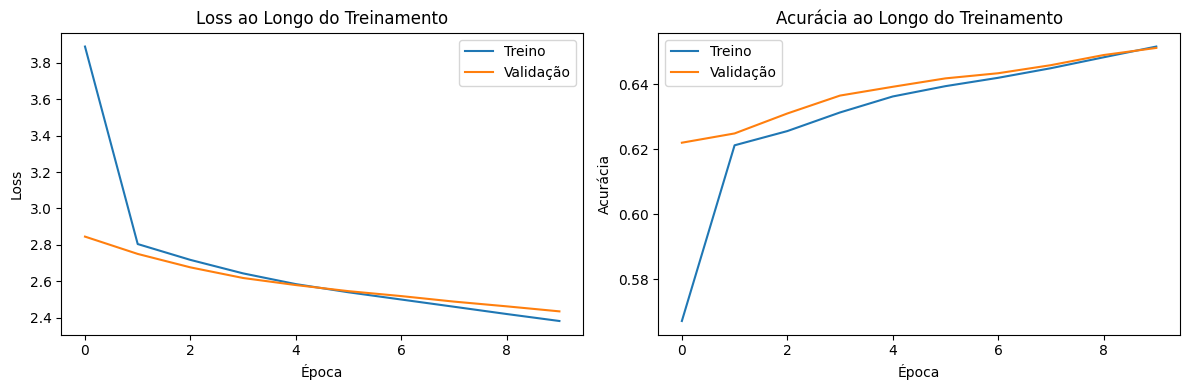

In [29]:
plt.figure(figsize=(12, 4))

# Plot da loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Valida√ß√£o')
plt.title('Loss ao Longo do Treinamento')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.legend()

# Plot da acur√°cia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Valida√ß√£o')
plt.title('Acur√°cia ao Longo do Treinamento')
plt.xlabel('√âpoca')
plt.ylabel('Acur√°cia')
plt.legend()

plt.tight_layout()
plt.show()

# ü§ñ Modelo 2: LSTM (Luong)


In [30]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)

    def call(self, inputs):
        """
        inputs: lista contendo [sa√≠das_do_decoder, sa√≠das_do_encoder]
          - decoder_outputs: tensor de shape (batch_size, tempo_decoder, LSTM_UNITS)
          - encoder_outputs: tensor de shape (batch_size, tempo_encoder, LSTM_UNITS)
        """
        decoder_outputs, encoder_outputs = inputs

        # Calcula os scores (pontua√ß√µes) via produto escalar entre as sa√≠das do decoder e do encoder
        # Resultado: (batch_size, tempo_decoder, tempo_encoder)
        scores = tf.matmul(decoder_outputs, encoder_outputs, transpose_b=True)

        # Aplica softmax para normalizar os scores em pesos de aten√ß√£o
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Calcula o vetor de contexto como a soma ponderada das sa√≠das do encoder
        # Resultado: (batch_size, tempo_decoder, LSTM_UNITS)
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        return context_vector

In [31]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model



def build_lstm_luong(vocab_size_pt, vocab_size_fr):

    # ----- Encoder -----
    # Entrada do encoder (texto em franc√™s)
    encoder_inputs = Input(shape=(None,), name="entrada_encoder")
    # Camada de embedding que transforma √≠ndices em vetores densos
    encoder_embedding = Embedding(input_dim=vocab_size_fr,
                                  output_dim=EMBEDDING_DIM,
                                  name="embedding_encoder")(encoder_inputs)
    # Camada LSTM que retorna sequ√™ncias (para a aten√ß√£o) e os estados finais
    encoder_outputs, state_h, state_c = LSTM(LSTM_UNITS,
                                             return_state=True,
                                             return_sequences=True,
                                             name="lstm_encoder")(encoder_embedding)
    # Estados finais do encoder que ser√£o usados para inicializar o decoder
    encoder_states = [state_h, state_c]

    # ----- Decoder -----
    # Entrada do decoder (texto em portugu√™s com token de in√≠cio)
    decoder_inputs = Input(shape=(None,), name="entrada_decoder")
    # Camada de embedding para o decoder
    decoder_embedding = Embedding(input_dim=vocab_size_pt,
                                  output_dim=EMBEDDING_DIM,
                                  name="embedding_decoder")(decoder_inputs)
    # Camada LSTM do decoder que retorna sequ√™ncias; inicializa com os estados do encoder
    decoder_lstm_outputs, _, _ = LSTM(LSTM_UNITS,
                                      return_sequences=True,
                                      return_state=True,
                                      name="lstm_decoder")(decoder_embedding, initial_state=encoder_states)

    # ----- Aten√ß√£o Luong -----
    # Calcula o vetor de contexto utilizando as sa√≠das do encoder e do decoder
    context_vector = LuongAttention(name="attention")([decoder_lstm_outputs, encoder_outputs])
    # Concatena o vetor de contexto com as sa√≠das do decoder para combinar as informa√ß√µes
    decoder_combined_context = Concatenate(axis=-1, name="concat_decoder")([decoder_lstm_outputs, context_vector])

    # ----- Camada de sa√≠da -----
    # Aplica uma camada densa (TimeDistributed) com softmax para gerar a probabilidade de cada token
    decoder_dense = TimeDistributed(Dense(vocab_size_pt, activation="softmax"), name="saida_final")
    decoder_outputs = decoder_dense(decoder_combined_context)

    # ----- Modelo final -----
    # O modelo recebe duas entradas: a sequ√™ncia do encoder e a sequ√™ncia do decoder.
    # E gera a sequ√™ncia de sa√≠da (tradu√ß√£o em portugu√™s).
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

In [32]:
lstm_luong_model = build_lstm_luong(vocab_size_pt, vocab_size_fr)
lstm_luong_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrando um resumo do modelo
lstm_luong_model.summary()

Model: "functional_6"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)              ‚îÉ Output Shape           ‚îÉ        Param # ‚îÉ Connected to           ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ entrada_encoder           ‚îÇ (None, None)           ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îÇ (InputLayer)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ entrada_decoder           ‚îÇ (None, None)           ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îÇ (InputLayer)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_encoder         ‚îÇ (None, None, 256)      ‚îÇ      9,465,088 ‚îÇ entrada_encoder[0][0]  ‚îÇ
‚îÇ (Embedding)               ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_decoder         ‚îÇ (None, None, 256)      ‚îÇ      9,603,840 ‚îÇ entrada_decoder[0][0]  ‚îÇ
‚îÇ (Embedding)               ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_encoder (LSTM)       ‚îÇ [(None, None, 512),    ‚îÇ      1,574,912 ‚îÇ embedding_encoder[0][‚Ä¶ ‚îÇ
‚îÇ                           ‚îÇ (None, 512), (None,    ‚îÇ                ‚îÇ                        ‚îÇ
‚îÇ                           ‚îÇ 512)]                  ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_decoder (LSTM)       ‚îÇ [(None, None, 512),    ‚îÇ      1,574,912 ‚îÇ embedding_decoder[0][‚Ä¶ ‚îÇ
‚îÇ                           ‚îÇ (None, 512), (None,    ‚îÇ                ‚îÇ lstm_encoder[0][1],    ‚îÇ
‚îÇ                           ‚îÇ 512)]                  ‚îÇ                ‚îÇ lstm_encoder[0][2]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ attention                 ‚îÇ (None, None, 512)      ‚îÇ              0 ‚îÇ

 Total params: 60,671,627 (231.44 MB)

 Trainable params: 60,671,627 (231.44 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = lstm_luong_model.fit(
    [X_train, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 47s 68ms/step - accuracy: 0.5701 - loss: 3.6519 - val_accuracy: 0.6501 - val_loss: 2.4456
Epoch 2/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 73ms/step - accuracy: 0.6515 - loss: 2.3698 - val_accuracy: 0.6642 - val_loss: 2.2647
Epoch 3/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 60ms/step - accuracy: 0.6711 - loss: 2.1141 - val_accuracy: 0.6956 - val_loss: 2.0537
Epoch 4/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 59ms/step - accuracy: 0.7142 - loss: 1.7489 - val_accuracy: 0.7265 - val_loss: 1.8446
Epoch 5/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 59ms/step - accuracy: 0.7522 - loss: 1.3958 - val_accuracy: 0.7432 - val_loss: 1.7364
Epoch 6/10
549/549 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 59ms/step - accuracy: 0.7913 - loss: 1.0933 - val_accuracy: 0.7498

# üìä Avalia√ß√£o Detalhada do Modelo LSTM

In [34]:
# 1. Distribui√ß√£o das Previs√µes Corretas vs Incorretas por Posi√ß√£o na Sequ√™ncia
def plot_accuracy_by_position(model, X_val, y_val, max_length=40):
    # Fazendo previs√µes
    predictions = model.predict([X_val, y_val[:, :-1]])
    predictions_classes = np.argmax(predictions, axis=-1)

    # Calculando acur√°cia por posi√ß√£o
    correct_by_position = []
    for pos in range(predictions.shape[1]):
        correct = np.sum(predictions_classes[:, pos] == y_val[:, pos+1])
        correct_by_position.append(correct / len(y_val))

    plt.figure(figsize=(12, 6))
    plt.plot(correct_by_position)
    plt.title('Acur√°cia por Posi√ß√£o na Sequ√™ncia')
    plt.xlabel('Posi√ß√£o na Sequ√™ncia')
    plt.ylabel('Acur√°cia')
    plt.grid(True)
    plt.show()

# 2. Distribui√ß√£o do Comprimento das Tradu√ß√µes
def plot_length_distribution(y_true, y_pred):
    # Calculando comprimentos (ignorando padding)
    true_lengths = [len([x for x in seq if x != 0]) for seq in y_true]
    pred_lengths = [len([x for x in seq if x != 0]) for seq in y_pred]

    plt.figure(figsize=(12, 6))
    plt.hist([true_lengths, pred_lengths], label=['Real', 'Previsto'],
             alpha=0.7, bins=20)
    plt.title('Distribui√ß√£o do Comprimento das Tradu√ß√µes')
    plt.xlabel('Comprimento da Sequ√™ncia')
    plt.ylabel('Frequ√™ncia')
    plt.legend()
    plt.show()

# 3, Heatmap das Palavras Mais Frequentemente Confundidas
def plot_confusion_heatmap(y_true, y_pred, tokenizer, top_k=20):
    # Pegando as palavras mais frequentes
    most_common = {v: k for k, v in tokenizer.word_index.items()}
    most_common = {i: most_common[i] for i in range(1, top_k+1)}

    # Criando matriz de confus√£o para as palavras mais comuns
    conf_matrix = confusion_matrix(
        y_true.flatten(),
        y_pred.flatten(),
        labels=list(range(1, top_k+1))
    )

    # Normalizando
    conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(15, 12))
    sns.heatmap(conf_matrix,
                xticklabels=list(most_common.values()),
                yticklabels=list(most_common.values()),
                annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Heatmap de Confus√£o para as Palavras Mais Frequentes')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Gerando as visualiza√ß√µes

32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 180ms/step


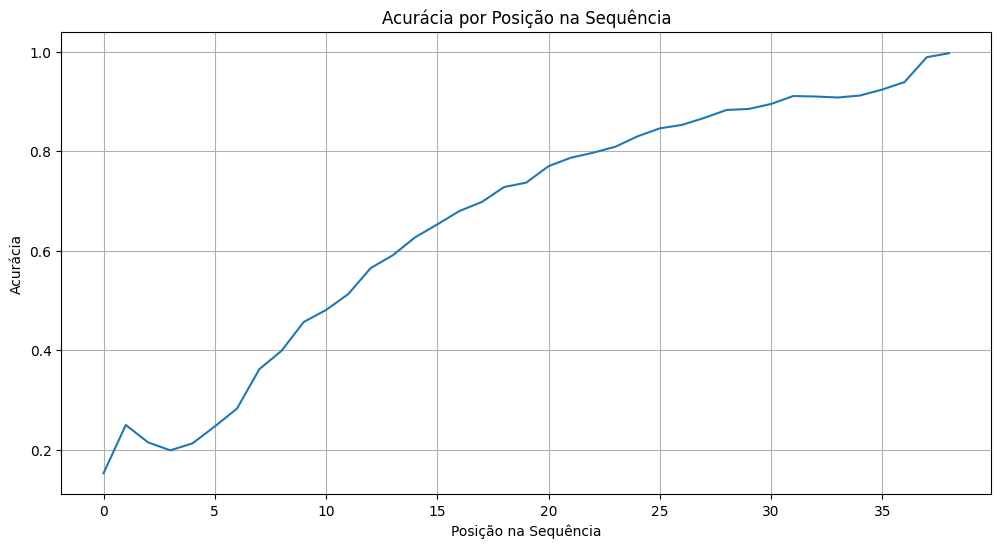

32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step


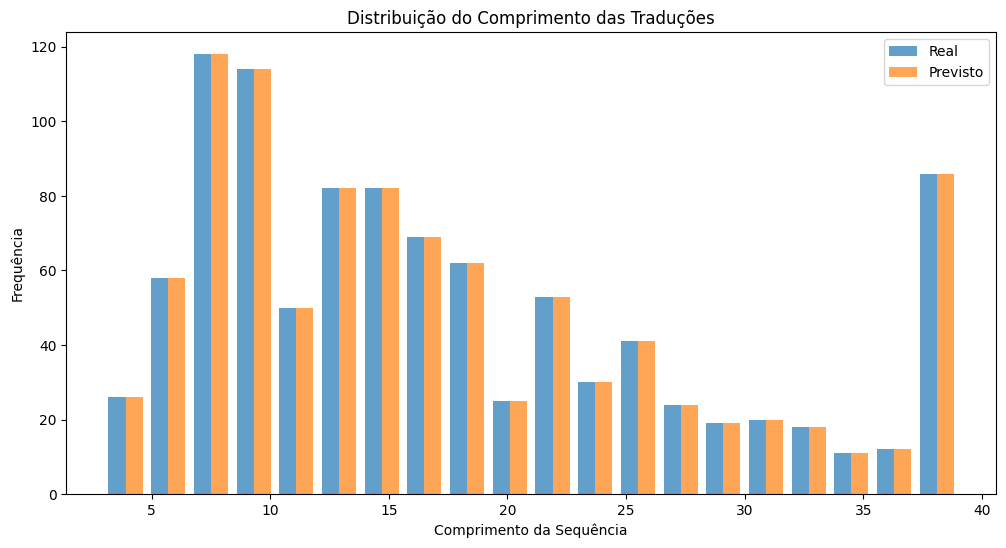

<ipython-input-34-5a6ddc1bd591>:50: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)


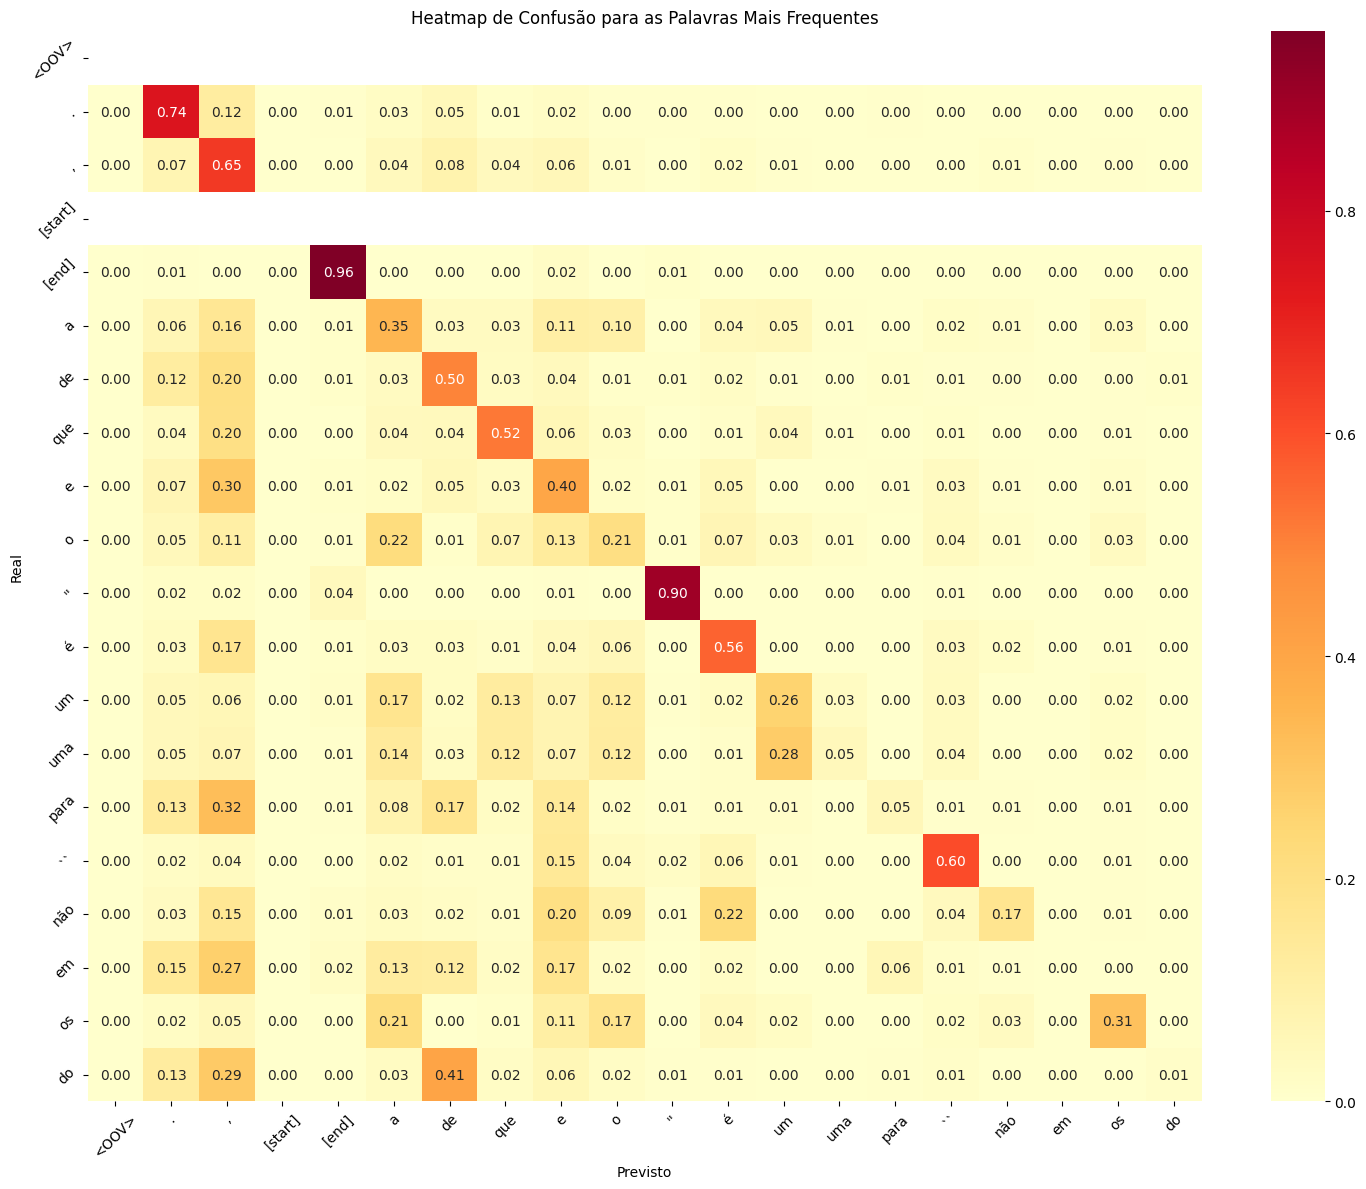


Legenda das visualiza√ß√µes:
1. Gr√°fico de Acur√°cia por Posi√ß√£o: Mostra como o modelo se comporta em diferentes posi√ß√µes da sequ√™ncia
2. Distribui√ß√£o de Comprimentos: Compara o tamanho das tradu√ß√µes reais vs. previstas
3. Heatmap: Mostra quais palavras frequentes s√£o mais confundidas entre si


In [35]:
# 1. Acur√°cia por posi√ß√£o
val_data = [X_train[-1000:], y_train[-1000:]]  # Usando √∫ltimas 1000 amostras como valida√ß√£o
plot_accuracy_by_position(model, val_data[0], val_data[1])

# 2. Distribui√ß√£o de comprimentos
predictions = model.predict([val_data[0], val_data[1][:, :-1]])
pred_classes = np.argmax(predictions, axis=-1)
plot_length_distribution(val_data[1][:, 1:], pred_classes)

# 3. Heatmap de confus√£o
plot_confusion_heatmap(val_data[1][:, 1:], pred_classes, tokenizer_pt)

print("\nLegenda das visualiza√ß√µes:")
print("1. Gr√°fico de Acur√°cia por Posi√ß√£o: Mostra como o modelo se comporta em diferentes posi√ß√µes da sequ√™ncia")
print("2. Distribui√ß√£o de Comprimentos: Compara o tamanho das tradu√ß√µes reais vs. previstas")
print("3. Heatmap: Mostra quais palavras frequentes s√£o mais confundidas entre si")